In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as cPickle
import xarray as xr

from driftutils import keep_in_domain as kid
from driftutils.utils import wrap_to_180
from plotutils.drift_map import dm_plot_driftmap_data

%matplotlib inline

In [49]:
def load_data(fname, pdir=None):
    if pdir:
        pname = os.path.basename(fname).split('.')[0]
        pfile = os.path.join(pdir, pname + '.pickle')
        if os.path.exists(pfile):
            ds = load_pickle(pfile)
        else:
            with xr.load_dataset(fname) as ds:
                save_pickle(pfile, ds)
        return ds
    else:
        with xr.load_dataset(fname) as ds:
            return ds
    
def save_pickle(fname, data):
    #print('Creating ' + os.path.basename(fname))
    with open(fname, 'wb') as handle:
        cPickle.dump(data, handle)

def load_pickle(fname):
    #print('Loading ' + os.path.basename(fname))
    with open(fname, 'rb') as handle:
        loaded_data = cPickle.load(handle)
    return loaded_data

def create_savedir(path):
    try:
        os.makedirs(path, exist_ok = True)
    except OSError as error:
        pass

def update_fnames(folder, labels, lab):
    files = [f for f in os.listdir(folder) if '.png' in f]
    gif_files = [f for f in os.listdir(folder) if '.gif' in f]
    for file in files:
        res = any(ele in file for ele in labels)
        if not res: 
            oldName = os.path.join(folder, file)
            n = os.path.splitext(file)[0]
            b = n + '_' + lab + '.png'
            newName = os.path.join(folder, b)
            # Rename the file
            os.rename(oldName, newName)
    for gfile in gif_files:
        os.remove(os.path.join(folder, gfile))
        
def set_up_map_plot(ax):
    ax.add_feature(cfeature.LAND.with_scale('10m'),
                   facecolor="lightgrey",
                   edgecolor='black',
                   linewidth=0.2,
                   alpha=1.0,
                   zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),
                   edgecolor='black',
                   linewidth=0.1,
                   alpha=1.0,
                   zorder=1)
    ax.gridlines(crs=crs.PlateCarree(),
                 draw_labels=['bottom', 'left'],
                 xformatter=LongitudeFormatter(),
                 xlabel_style={'rotation': 45, 'ha': 'center'},
                 yformatter=LatitudeFormatter(),
                 ylabel_style={'rotation': 45, 'ha': 'center'},
                 linewidth=2, color='gray', alpha=0.1, 
                 linestyle='-', zorder=1)
    return ax

def create_subplots_figure(nrows=1, ncols=1, map=False, fsize=None, ratio=1.5, axsize=6):
    """ratio is expected to be width/height so that a ratio of 2 will
    give a plot that is twice as wide as it is tall"""
    if not fsize:
        fsize = (ratio*(axsize*nrows), axsize*ncols)
    if map:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize,
                                subplot_kw={'projection': crs.PlateCarree()})
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize)
    return fig, axs.flatten()

def plot_tracks(ncfile, lab, pdir=None, axsize=None):
    
    ds = load_data(ncfile, pdir=pdir)
    fig, axs = create_subplots_figure(nrows=1, ncols=1, map=True, axsize=axsize)
    ax = axs[0]
    set_up_map_plot(ax)

    for mr in ds.model_run.values:
        lons = ds.mod_lon[mr].values
        lats = ds.mod_lat[mr].values
        #if not np.isnan(lons).all():
        ax.plot(lons, lats, color='black', linestyle='-', linewidth=0.5)
        ax.plot(lons, lats, 'o', color='black', markersize=1)
        ax.plot(lons[0], lats[0], 'o', color='green', markersize=3)
        ax.set_title(lab)
        
        
def plot_tracks_multi(datasets, savedir, labels, colors, pdir=None, axsize=None):
    
    fig, axs = create_subplots_figure(nrows=1, ncols=1, map=True, axsize=axsize)
    ax = axs[0]
    set_up_map_plot(ax)
    
    for ds, lab, col in zip(datasets, labels, colors):
        #ds = load_data(ncfile, pdir=pdir)
        for mr in ds.model_run.values:
            lons = ds.mod_lon[mr].values
            lats = ds.mod_lat[mr].values
            #if not np.isnan(lons).all():
            leglab = '_no_label_'
            if mr == 0:
                leglab = lab
            ax.plot(lons, lats, color=col, linestyle='-', linewidth=0.8, label=leglab)
            #ax.plot(lons, lats, 'o', color='black', markersize=1)
            ax.plot(lons[0], lats[0], 'o', color='green', markersize=3)
            #ax.set_title(lab)
            
    plt.legend()
    plt.savefig(os.path.join(savedir, 'stokes_mldp.png'))

In [50]:
pdir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/stokes_drift/stokes_mldp/dwt_output/pickled_output"
dwt_outdir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/output_general_dwt_tests"
waves_outdir = os.path.join(dwt_outdir, "driftmap_mldp_stokes_waves/output")
nowaves_outdir = os.path.join(dwt_outdir, "driftmap_mldp_stokes_nowaves/output")
savedir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/stokes_drift/stokes_mldp/dwt_output/comparison_plots/"
wavesout = os.path.join(waves_outdir, 'ciops-e_ml_2023032300_P1D.nc')
nowavesout = os.path.join(nowaves_outdir, 'ciops-e_ml_2023032300_P1D.nc')

In [51]:
waves = load_data(wavesout, pdir=pdir)
nowaves = load_data(nowavesout, pdir=pdir)

In [52]:
waves_lons = list(waves.mod_lat.values.flatten())
nowaves_lons = list(nowaves.mod_lat.values.flatten())

df = pd.DataFrame({'waves': waves_lons, 'nowaves': nowaves_lons})
df['subt'] = df['waves'] - df['nowaves']
print(df)

real_subt = [i for i in df.subt.values if i != 0 and not np.isnan(i)]
if real_subt:
    print('\n', real_subt)
else:
    print('\nno diffence between the lons')

          waves    nowaves  subt
0     45.000000  45.000000   0.0
1     44.988316  44.988316   0.0
2     44.974541  44.974541   0.0
3     44.959660  44.959660   0.0
4     44.945454  44.945454   0.0
...         ...        ...   ...
2395  51.688473  51.688473   0.0
2396  51.666119  51.666119   0.0
2397  51.644524  51.644524   0.0
2398  51.624336  51.624336   0.0
2399  51.605515  51.605515   0.0

[2400 rows x 3 columns]

no diffence between the lons


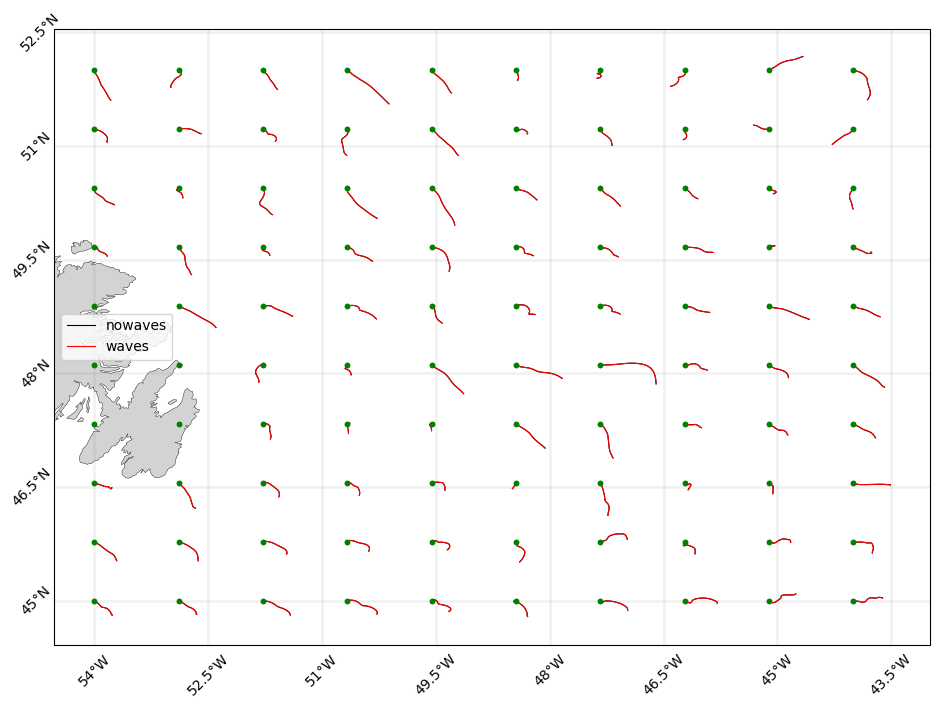

In [53]:
labels = ['nowaves', 'waves']  
datasets = [nowaves, waves] 
colors = ['black', 'red']


## make a simple map plot
plot_tracks_multi(datasets, savedir, labels, colors, axsize=8)
